# Example on Guinea CCDR

This notebook enables to post-process the results of the Energy Planning Model (EPM) to obtain the main figures. 
Importantly, it enables to compare multiple scenarios.
In the result of the folder, there are subfolders for each scenario. The notebook will loop over all the scenarios to get the data, and then plot the figures.


**Disclamer: You need to adapt to your own case, as the EPM results are specific to each case.**


Here, we will use the results of the EPM for the CCDR of Guinea. 
The EPM .gdx files are stored in the `/output/simulations_run_20250108_103948` folder. 
The figures will be stored in the `/output/simulations_run_20250108_103948/img` folder.

For the sake of this example, we will display the figures in the notebook, but there are usually not displayed in the notebook.

In [1]:
from utils import *

## Loading data and main parameters

In [2]:
REGION_NAME = 'Guinea'
RESULTS_FOLDER = 'simulations_run_20250108_103949' # Name of the folder containing the results
DISPLAY = True # Usually set to False to avoid displaying the graphs

# Rename scenarios for better visualization
SCENARIOS_RENAME = {
    'simulation_baseline': 'Baseline',
    'simulation_HydroLow': 'Low Hydro',
    'simulation_HydroHigh': 'High Hydro',
    'simulation_HydroMedium': 'Medium Hydro',
    'simulation_EmissionCstr': 'Emission Constant',
    'simulation_NZ': 'Net Zero',
    'simulation_DoubleFossilCost': 'DoubleFossilCost',
    'simulation_HigherFossilCost': 'HigherFossilCost',
    'simulation_HigherHydroReserve': 'HigherHydroReserve',
    'simulation_LowStorageCost': 'Low Storage Cost',
    'simulation_IndependentHydro': 'Independent Hydro',
    'simulation_WorstCase': 'WorstCase',
    'simulation_HigherFuelPrice': 'High Fuel Price',
    'simulation_HighFuelPriceLowHydro': 'HighFuelPrice+LowHydro',
    'simulation_HPO_IPP': 'HPO IPP',
    'simulation_DemandHigh': 'High Demand',
    'simulation_HydroStochastic': 'HydroStochastic',
    'simulation_HydroStochasticCC': 'HydroStochasticCC',
    'simulation_NZStochastic': 'NZStochastic',
    'simulation_NZStochasticCC': 'NZStochasticCC',
}



YEAR = 2050
DISCOUNT_RATE = 0.06
SELECT_XAXIS = [2035, 2050] # x-axis displayed range for the graphs

selected_scenario = 'Baseline'
scenario_order = ['Baseline', 'Emission Constant', 'Net Zero', 
                  'HydroStochastic', 'NZStochastic', 'HydroStochasticCC', 'NZStochasticCC',
                  'Low Hydro', 'Medium Hydro', 'High Hydro', 'Independent Hydro', 'High Fuel Price', 'HPO IPP',
                  'Low Storage Cost', 'High Demand']

### Read input and output data

In [3]:
# Create the folder path
RESULTS_FOLDER = os.path.join('..', 'output', RESULTS_FOLDER)
GRAPHS_RESULTS = 'img'
GRAPHS_RESULTS = os.path.join(RESULTS_FOLDER, GRAPHS_RESULTS)
if not os.path.exists(GRAPHS_RESULTS):
    os.makedirs(GRAPHS_RESULTS)
    print(f'Created folder {GRAPHS_RESULTS}')

# Read the plot specifications
dict_specs = read_plot_specs()

# Extract and process EPM inputs
epm_input = extract_epm_folder(RESULTS_FOLDER, file='input.gdx')
epm_input = process_epm_inputs(epm_input, dict_specs, scenarios_rename=SCENARIOS_RENAME)
mapping_gen_fuel = epm_input['pGenDataInput'].loc[:, ['scenario', 'generator', 'fuel1']]

# Extract and process EPM results
epm_results = extract_epm_folder(RESULTS_FOLDER, file='epmresults.gdx')
epm_results = process_epm_results(epm_results, dict_specs, scenarios_rename=SCENARIOS_RENAME,
                                  mapping_gen_fuel=mapping_gen_fuel)

# Add plant colors to the dictionary
if True:
    temp = epm_results['pEnergyByPlant'].copy()
    plant_fuel_pairs = temp[['generator', 'fuel1']].drop_duplicates()
    plant_fuel_pairs['colors'] = plant_fuel_pairs['fuel1'].map(dict_specs['colors'])
    plant_to_color = dict(zip(plant_fuel_pairs['generator'], plant_fuel_pairs['colors']))
    dict_specs['colors'].update(plant_to_color)

/opt/anaconda3/envs/gamsenv/lib/python3.8/site-packages/gams/transfer/containers/_container.py:73: UserWarning: The GAMS version (48.2.0) differs from the API version (47.6.0).
  ws = GamsWorkspace()
/opt/anaconda3/envs/gamsenv/lib/python3.8/site-packages/gams/core/numpy/gams2numpy.py:45: UserWarning: The GAMS version (48.2.0) differs from the API version (47.6.0).
  ws = GamsWorkspace(system_directory=system_directory)
/opt/anaconda3/envs/gamsenv/lib/python3.8/site-packages/gams/transfer/containers/_container.py:73: UserWarning: The GAMS version (48.2.0) differs from the API version (47.6.0).
  ws = GamsWorkspace()
/opt/anaconda3/envs/gamsenv/lib/python3.8/site-packages/gams/core/numpy/gams2numpy.py:45: UserWarning: The GAMS version (48.2.0) differs from the API version (47.6.0).
  ws = GamsWorkspace(system_directory=system_directory)
/opt/anaconda3/envs/gamsenv/lib/python3.8/site-packages/gams/transfer/containers/_container.py:73: UserWarning: The GAMS version (48.2.0) differs from t

pPlantFuelDispatch not found in epm_dict


### Ad hoc

In [4]:
# Export energy by plant in .csv file to check the results
temp = epm_results['pEnergyByPlant'].pivot_table(index=['scenario', 'zone', 'generator', 'fuel1'], columns='year',
                                                 values='value')
temp.to_csv(f'{RESULTS_FOLDER}/pEnergyPlants.csv', encoding='latin-1')

In [5]:
# Add information on the capacity mix in the Master Plan to compare with our simulation
capacity_mp = 'guinea/capacity_mix_master_plan.csv'
capacity_mp = pd.read_csv(capacity_mp, index_col=0)
capacity_mp = capacity_mp.stack().reset_index()
capacity_mp.columns = ['year', 'fuel', 'value']
capacity_mp['scenario'] = 'Master Plan'
capacity_mp['zone'] = 'Guinea'
epm_results['pCapacityFuel'] = pd.concat([epm_results['pCapacityFuel'], capacity_mp], ignore_index=True)

# Make figures

## Make summary

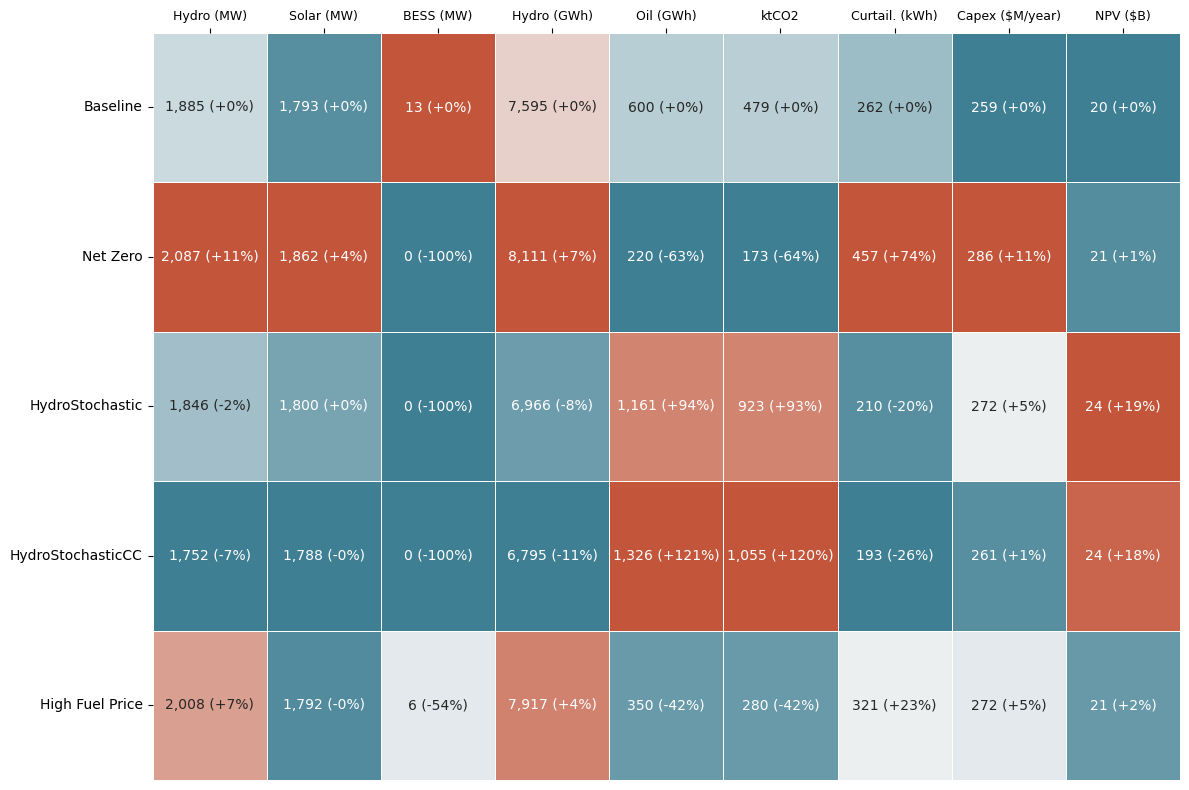

In [6]:
filename = f'{GRAPHS_RESULTS}/SummaryTable.png'
filename = False # Only for display in the notebook
make_heatmap_plot(epm_results, filename, percentage=True, scenario_order=scenario_order, discount_rate=DISCOUNT_RATE)

### Focus on one scenario
For example, useful to show the baseline.

#### Make Energy and Capacity Mix Pie Plot for one selected scenario

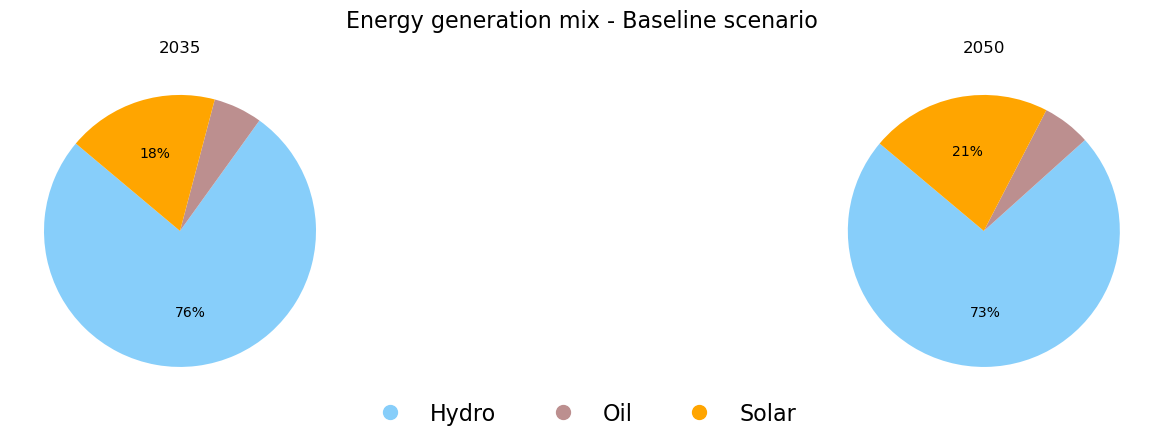

In [7]:
temp = epm_results['pEnergyFuel'].copy()
temp = temp[temp['scenario'] == selected_scenario]
fuel_excluded = ['Battery Storage', 'Pumped-Hydro Storage']
temp = temp[temp['fuel'].isin(fuel_excluded) == False]
temp = temp.loc[temp['year'].isin(SELECT_XAXIS)].groupby(['year', 'fuel']).agg({'value': 'sum'}).reset_index()
temp['value'] = temp['value'].apply(lambda x: 0 if x < 0 else x)
t = '_'.join([str(y) for y in SELECT_XAXIS])
filename = f'{GRAPHS_RESULTS}/EnergyGenerationMixPie_{t}_{selected_scenario}.png'
filename = False # Only for display in the notebook
subplot_pie(temp, 'fuel', dict_specs['colors'], 'year',
            title=f'Energy generation mix - {selected_scenario} scenario',
            percent_cap=6, filename=filename)


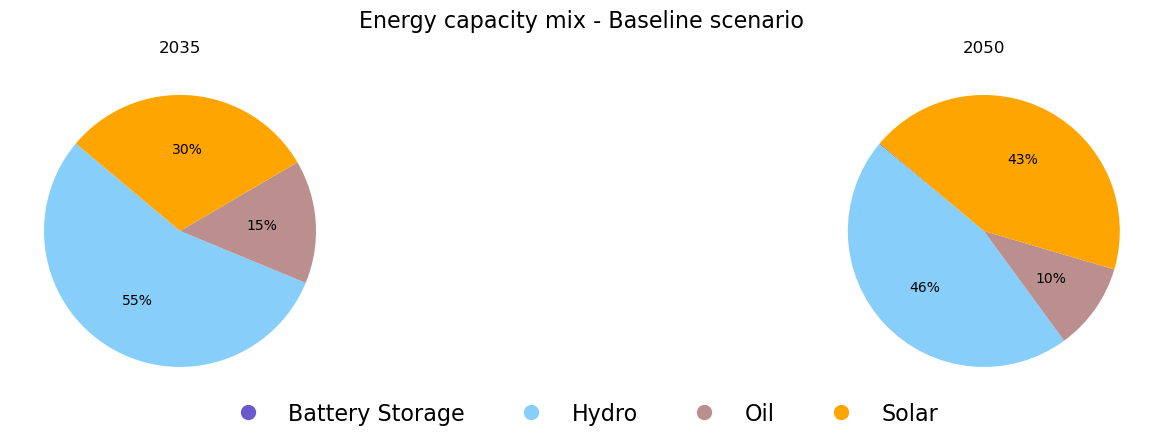

In [8]:
temp = epm_results['pCapacityFuel'].copy()
temp = temp.loc[temp['year'].isin(SELECT_XAXIS)].groupby(['year', 'fuel']).agg({'value': 'sum'}).reset_index()
temp['value'] = temp['value'].apply(lambda x: 0 if x < 0 else x)

t = '_'.join([str(y) for y in SELECT_XAXIS])
filename = f'{GRAPHS_RESULTS}/EnergyCapacityMixPie_{t}_{selected_scenario}.png'
filename = False # Only for display in the notebook
subplot_pie(temp, 'fuel', dict_specs['colors'], 'year',
            title=f'Energy capacity mix - {selected_scenario} scenario',
            percent_cap=6, filename=filename)

#### Make Stack Area Plot for Capacity and Energy mix for one selected scenario

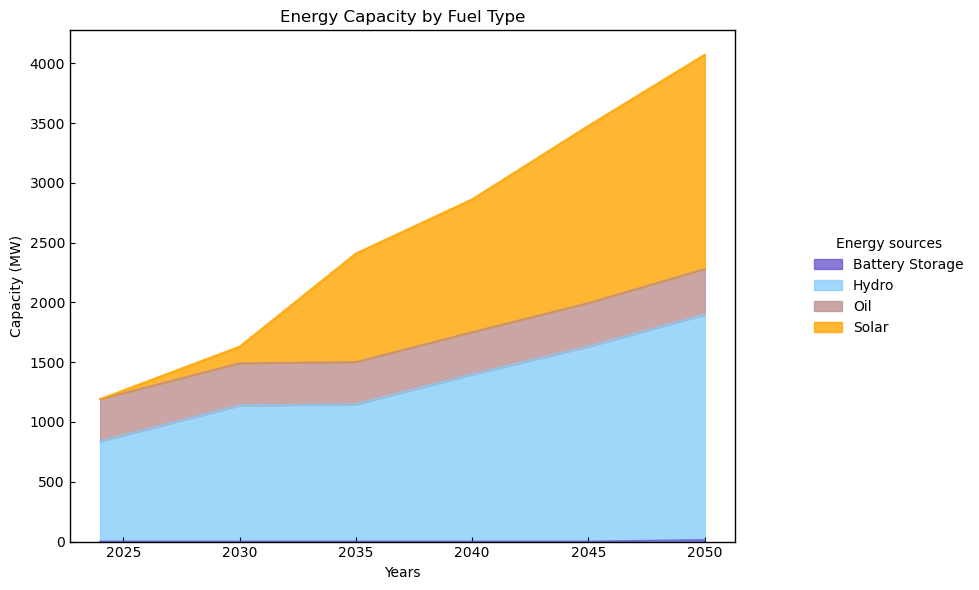

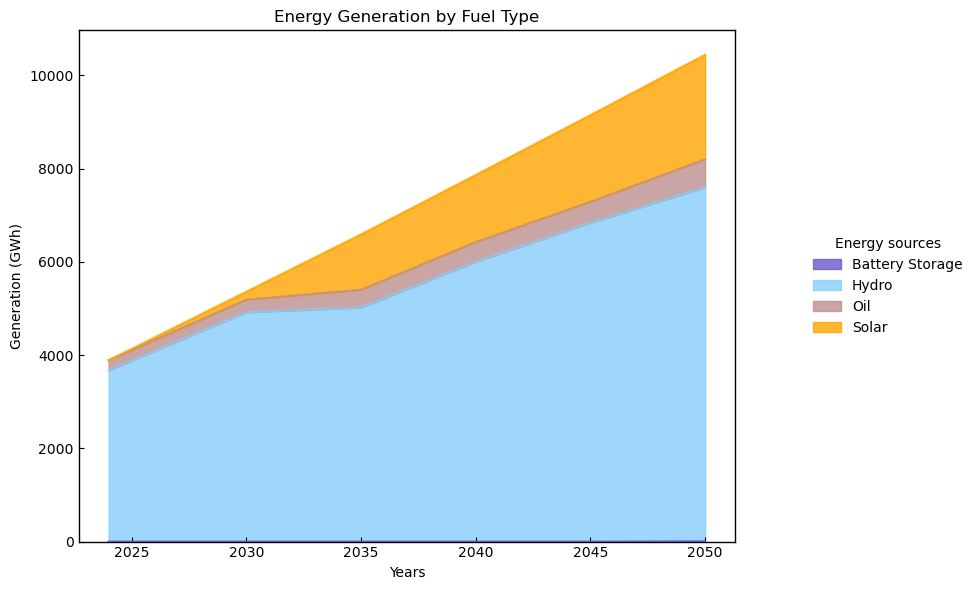

In [9]:
filename = f'{GRAPHS_RESULTS}/CapacityMixStackedAreaPlot_{selected_scenario}.png'
filename = False # Only for display in the notebook
make_stacked_areaplot(epm_results['pCapacityFuel'], filename, dict_specs['colors'], column_xaxis='year', column_value='value',
                  column_stacked='fuel', title='Energy Capacity by Fuel Type', y_label='Capacity (MW)',
                  legend_title='Energy sources', figsize=(10, 6), selected_scenario=selected_scenario)

filename = f'{GRAPHS_RESULTS}/EnergyMixStackedAreaPlot_{selected_scenario}.png'
filename = False # Only for display in the notebook
make_stacked_areaplot(epm_results['pEnergyFuel'], filename, dict_specs['colors'], column_xaxis='year', column_value='value',
                  column_stacked='fuel', title='Energy Generation by Fuel Type', y_label='Generation (GWh)',
                  legend_title='Energy sources', figsize=(10, 6), selected_scenario=selected_scenario)

# Not yet implemented
if False:
    filename = f'{GRAPHS_RESULTS}/EnergyPlantsStackedAreaPlot_{selected_scenario}.png'
    filename = False # Only for display in the notebook
    make_stacked_areaplot(epm_results['pEnergyByPlant'], filename, dict_specs['colors'], column_xaxis='year', column_value='value',
                      column_stacked='generator', title='Energy Generation by Plant', y_label='Generation (GWh)',
                      legend_title='Energy sources', figsize=(10, 6), selected_scenario=selected_scenario)

#### Make Dispatch

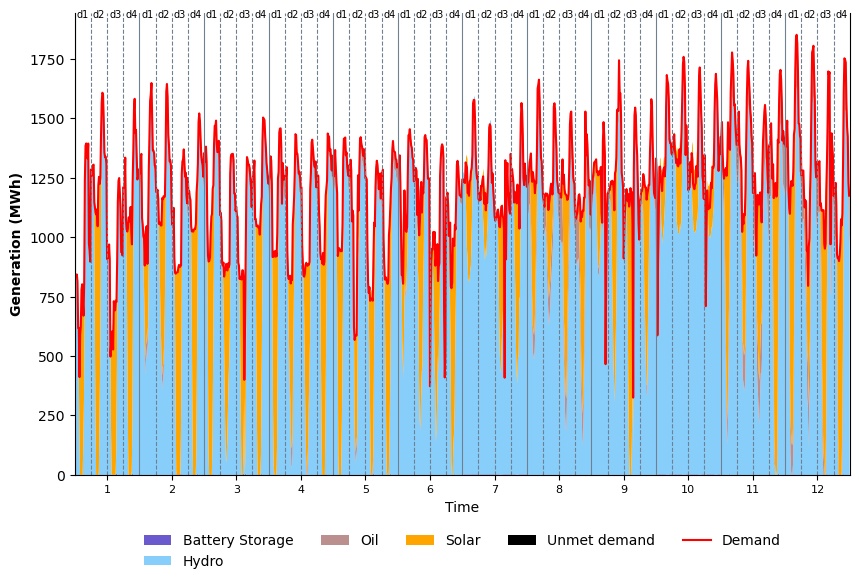

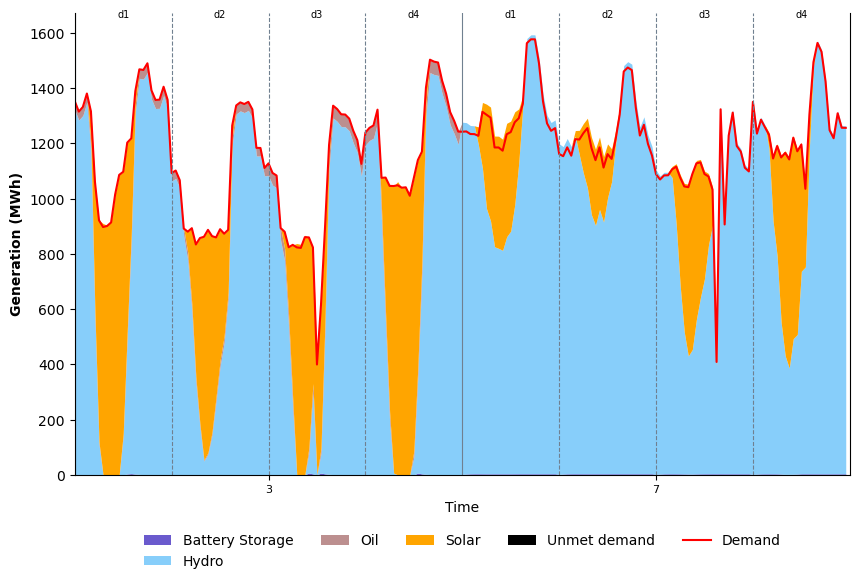

In [10]:
demand = epm_results['pDispatch'].loc[epm_results['pDispatch'].attribute.isin(['Demand'])]

dfs_to_plot_area = {
    'pFuelDispatch': epm_results['pFuelDispatch'],
    'pDispatch': epm_results['pDispatch'].loc[epm_results['pDispatch'].attribute.isin(['Unmet demand', 'Exports'])]
}

dfs_to_plot_line = {
    'pDispatch': demand
}

# Make dispatch plot for all years all scenarios
if False:
    for scenario in epm_results['pFuelDispatch']['scenario'].unique().tolist():
        for year in SELECT_XAXIS:
            if year in epm_results['pFuelDispatch']['year'].unique():
                make_fuel_dispatchplot(dfs_to_plot_area, dfs_to_plot_line, GRAPHS_RESULTS, dict_specs['colors'],
                                                 zone=REGION_NAME, year=year, scenario=scenario,
                                                 fuel_grouping=None, select_time=None)
        if 2050 in epm_results['pFuelDispatch']['year'].unique():
            year, select_time = 2050, {'season': ['3', '7']}
            make_fuel_dispatchplot(dfs_to_plot_area, dfs_to_plot_line, GRAPHS_RESULTS, dict_specs['colors'],
                                             zone=REGION_NAME, year=year, scenario=scenario,
                                             fuel_grouping=None, select_time=select_time, legend_loc='right')
else:
    filename = f'{GRAPHS_RESULTS}/Dispatch_{selected_scenario}.png'
    filename = None # Only for display in the notebook
    make_fuel_dispatchplot(dfs_to_plot_area, dfs_to_plot_line, dict_specs['colors'],
                                     zone=REGION_NAME, year=2050, scenario=selected_scenario,
                                     fuel_grouping=None, select_time=None, filename=filename)   
    
    select_time = {'season': ['3', '7']}
    make_fuel_dispatchplot(dfs_to_plot_area, dfs_to_plot_line, dict_specs['colors'],
                                 zone=REGION_NAME, year=2050, scenario=selected_scenario,
                                 fuel_grouping=None, select_time=select_time, filename=filename) 


### Scenario comparison

#### Make Capacity Mix scenario comparison

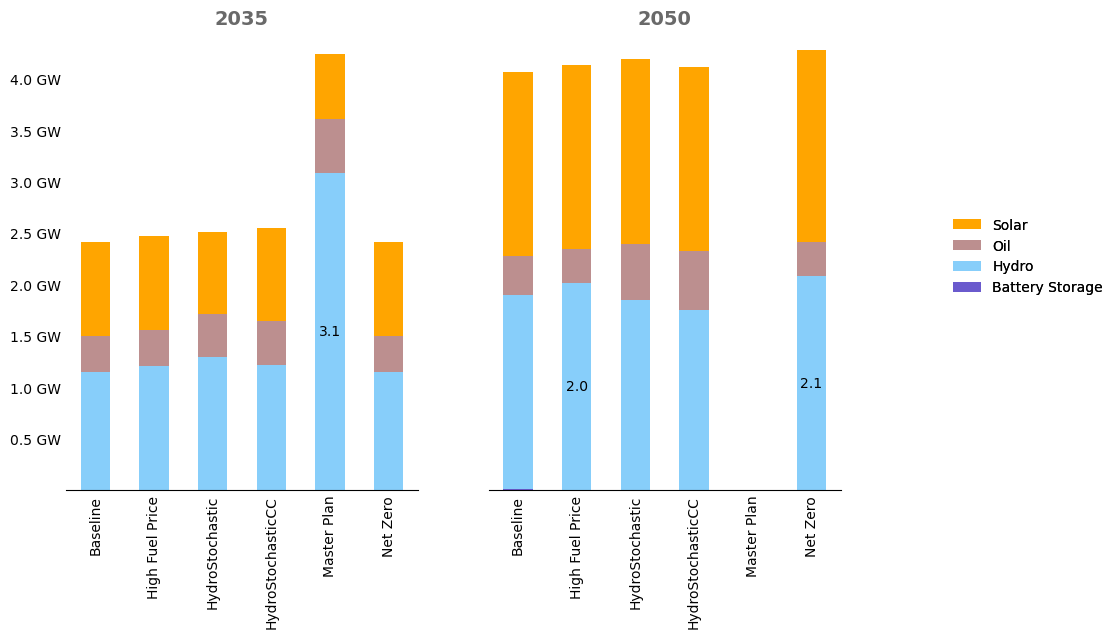

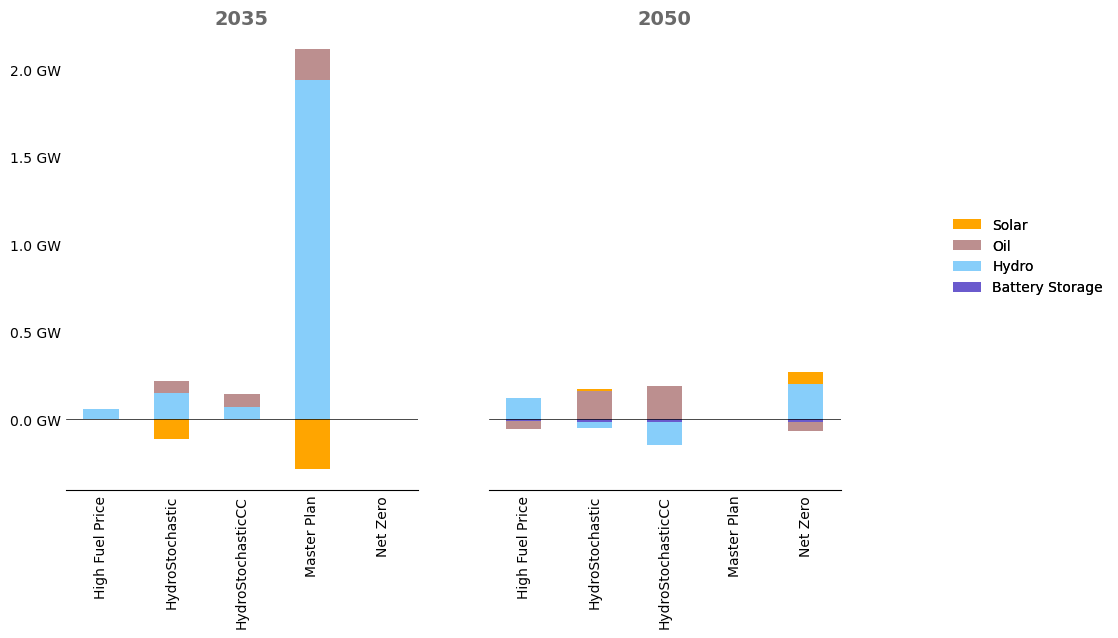

In [11]:
df = epm_results['pCapacityFuel'].copy()
df['value'] = df['value'] / 1e3
filename = f'{GRAPHS_RESULTS}/CapacityMixClusteredStackedAreaPlot.png'
filename = None # Only for display in the notebook
make_stacked_barplot(df, filename, dict_specs['colors'], column_stacked='fuel', column_xaxis='year',
                          column_value='value', column_multiple_bars='scenario', select_xaxis=SELECT_XAXIS,
                          format_y=lambda y, _: '{:.1f} GW'.format(y))

# Make difference with baseline to highlight changes
if 'Baseline' in df['scenario'].unique() and len(df['scenario'].unique()) > 1:
    df_diff = df.pivot_table(index=['zone', 'year', 'fuel'], columns='scenario', values='value')
    df_diff = (df_diff.T - df_diff['Baseline']).T
    df_diff = df_diff.drop('Baseline', axis=1)
    df_diff = df_diff.stack().reset_index()
    df_diff.rename(columns={0: 'value'}, inplace=True)

    filename = f'{GRAPHS_RESULTS}/CapacityMixClusteredStackedAreaPlot_Diff.png'
    filename = None # Only for display in the notebook
    make_stacked_barplot(df_diff, filename, dict_specs['colors'], column_stacked='fuel', column_xaxis='year',
                              column_value='value', column_multiple_bars='scenario', select_xaxis=SELECT_XAXIS,
                              format_y=lambda y, _: '{:.1f} GW'.format(y))

#### New capacity installed

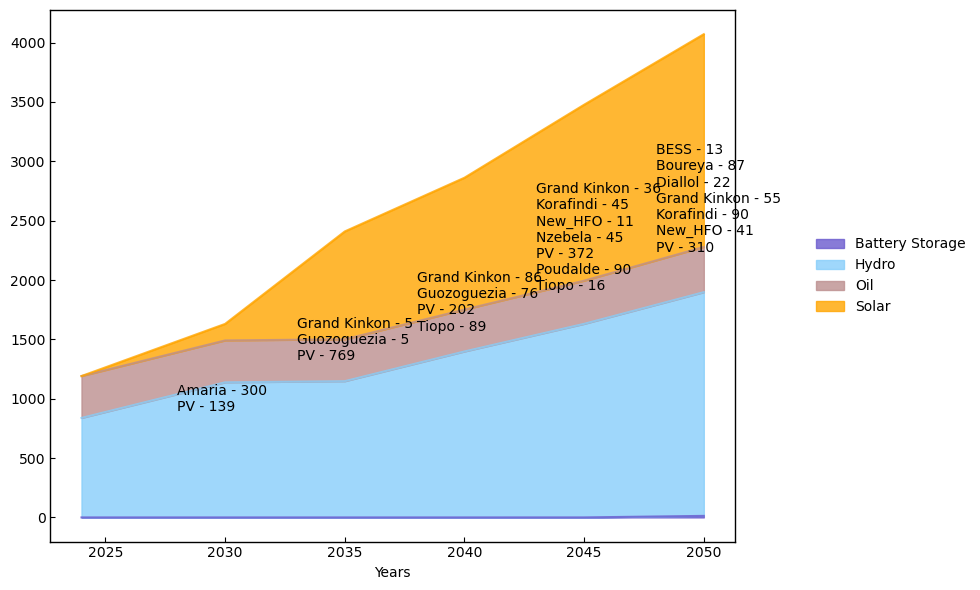

In [12]:
df = epm_results['pCapacityPlan'].copy()
df = df[df['scenario'] == selected_scenario]
df.sort_values('fuel1', inplace=True)
# complete year with 0 capacity when no data
years =  epm_results['pCapacityPlan']['year'].unique()

result = {}
for n, g in df.groupby(['generator']):
    g.set_index('year', inplace=True)
    g = g.loc[:, 'value']
    g = g.reindex(years, fill_value=0)
    g.sort_index(inplace=True)
    g = g.diff()
    g = g[g > 1].to_dict()
    g = {k: '{} - {:.0f}'.format(n[0], i) for k, i in g.items()}
    # if k in result.keys() add values to the existing dictionary
    for k, i in g.items():
        if k in result.keys():
            result[k] += '\n' + i
        else:
            result[k] = i
        
filename = f'{GRAPHS_RESULTS}/NewCapacityInstalledTimeline_{selected_scenario}.png'
filename = None # Only for display in the notebook
make_stacked_areaplot(df, filename, dict_specs['colors'], column_xaxis='year', column_value='value', column_stacked='fuel1', annotate=result)

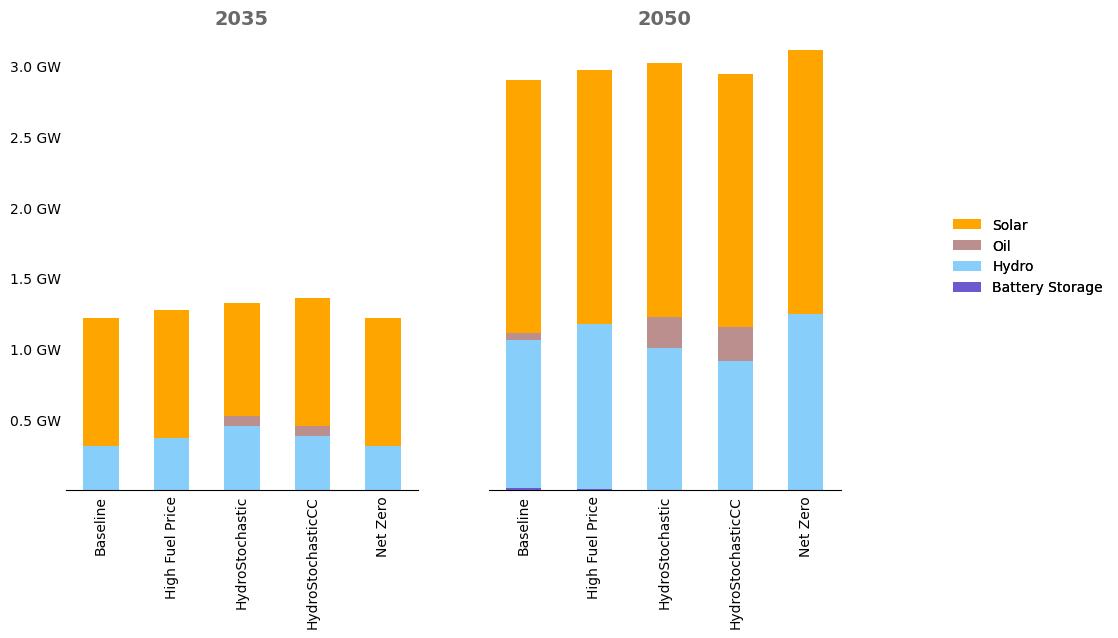

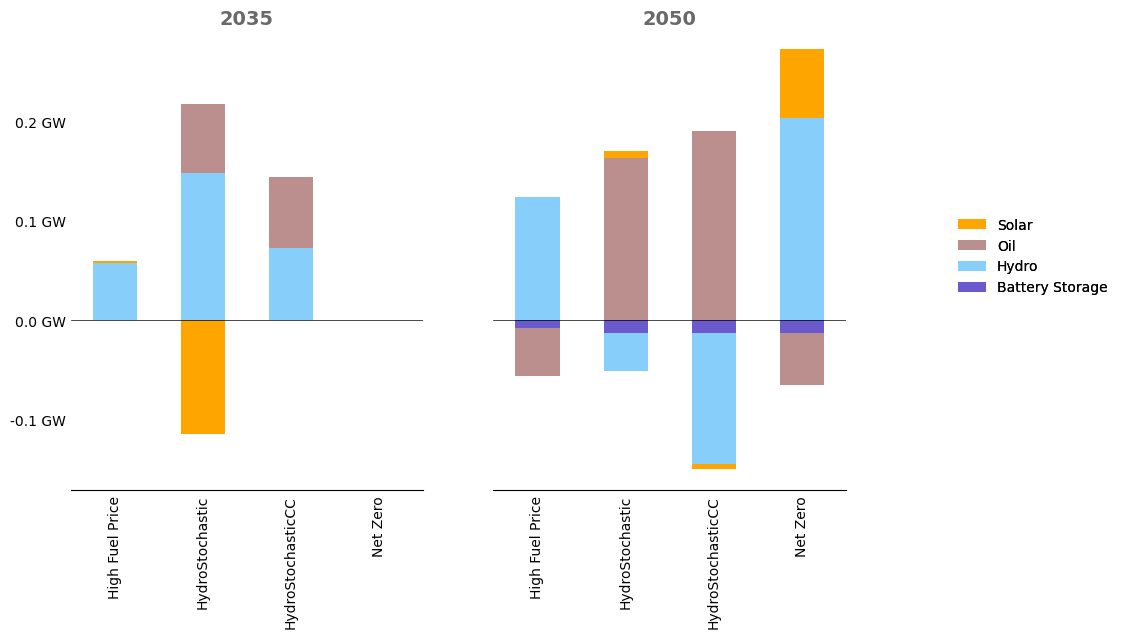

In [13]:
df = epm_results['pNewCapacityFuelCountry'].copy()
# calculate cumulative capacity by year
df = df.sort_values(by=['scenario', 'zone', 'fuel', 'year'])
df['value'] = df.groupby(['scenario', 'zone', 'fuel'])['value'].cumsum()
df['value'] = df['value'] / 1e3
filename = f'{GRAPHS_RESULTS}/NewCapacityMixClusteredStackedAreaPlot.png'
filename = None # Only for display in the notebook
make_stacked_barplot(df, filename, dict_specs['colors'], column_stacked='fuel', column_xaxis='year',
                          column_value='value', column_multiple_bars='scenario', select_xaxis=SELECT_XAXIS,
                          format_y=lambda y, _: '{:.1f} GW'.format(y))

# Make difference with baseline to highlight changes
if 'Baseline' in df['scenario'].unique() and len(df['scenario'].unique()) > 1:
    df_diff = df.pivot_table(index=['zone', 'year', 'fuel'], columns='scenario', values='value')
    df_diff = (df_diff.T - df_diff['Baseline']).T
    df_diff = df_diff.drop('Baseline', axis=1)
    df_diff = df_diff.stack().reset_index()
    df_diff.rename(columns={0: 'value'}, inplace=True)

    filename = f'{GRAPHS_RESULTS}/NewCapacityMixClusteredStackedAreaPlot_Diff.png'
    filename = None # Only for display in the notebook
    make_stacked_barplot(df_diff, filename, dict_specs['colors'], column_stacked='fuel', column_xaxis='year',
                              column_value='value', column_multiple_bars='scenario', select_xaxis=SELECT_XAXIS,
                              format_y=lambda y, _: '{:.1f} GW'.format(y))

#### Make Energy Mix scenario comparison

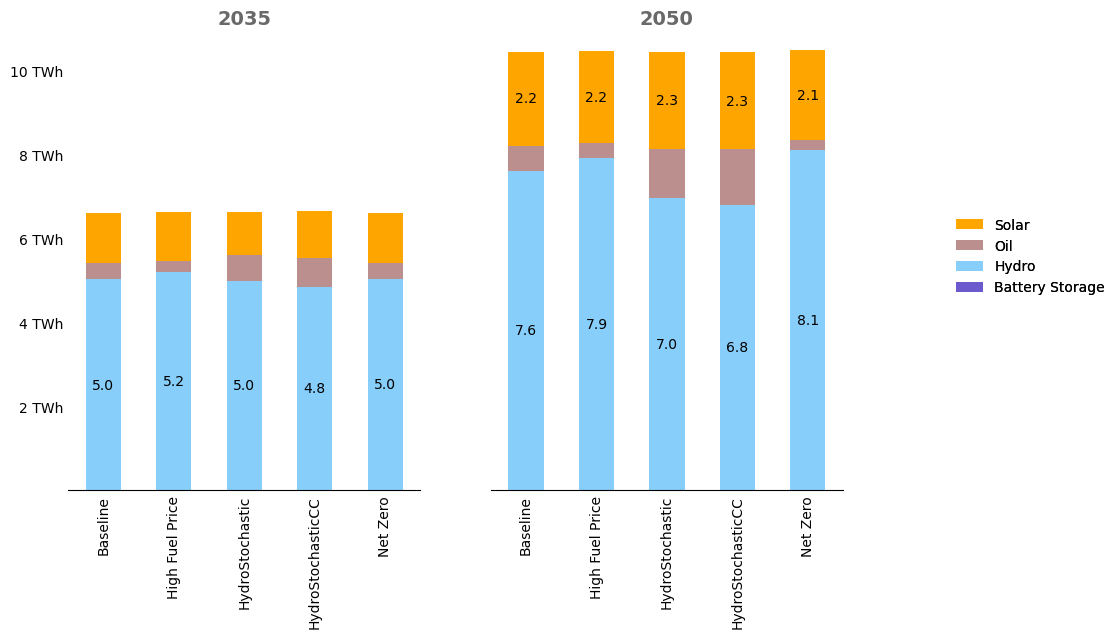

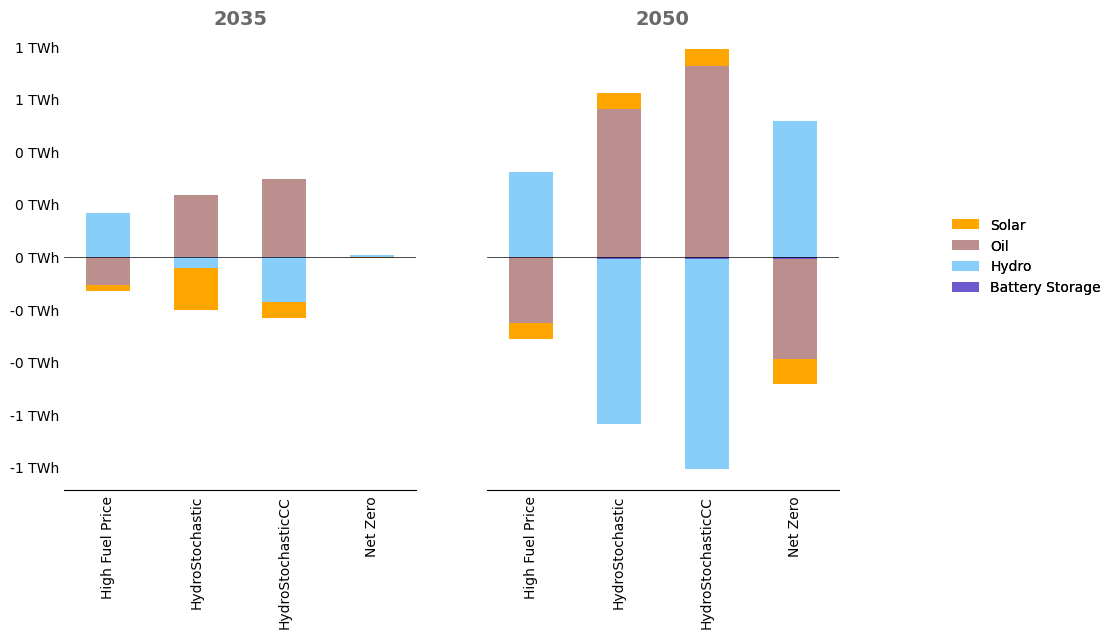

In [14]:
df = epm_results['pEnergyFuel'].copy()
df['value'] = df['value'] / 1e3
filename = f'{GRAPHS_RESULTS}/EnergyMixClusteredStackedAreaPlot.png'
filename = None # Only for display in the notebook
make_stacked_barplot(df, filename, dict_specs['colors'], column_stacked='fuel', column_xaxis='year',
                          column_value='value', column_multiple_bars='scenario', select_xaxis=SELECT_XAXIS,
                          format_y=lambda y, _: '{:.0f} TWh'.format(y))

# Make difference with baseline to highlight changes
if 'Baseline' in df['scenario'].unique() and len(df['scenario'].unique()) > 1:
    df_diff = df.pivot_table(index=['zone', 'year', 'fuel'], columns='scenario', values='value')
    df_diff = (df_diff.T - df_diff['Baseline']).T
    df_diff = df_diff.drop('Baseline', axis=1)
    df_diff = df_diff.stack().reset_index()
    df_diff.rename(columns={0: 'value'}, inplace=True)

    filename = f'{GRAPHS_RESULTS}/EnergyMixClusteredStackedAreaPlot_Diff.png'
    filename = None # Only for display in the notebook
    make_stacked_barplot(df_diff, filename, dict_specs['colors'], column_stacked='fuel', column_xaxis='year',
                              column_value='value', column_multiple_bars='scenario', select_xaxis=SELECT_XAXIS,
                              format_y=lambda y, _: '{:.0f} TWh'.format(y))

#### Make Energy Reserve scenario comparison

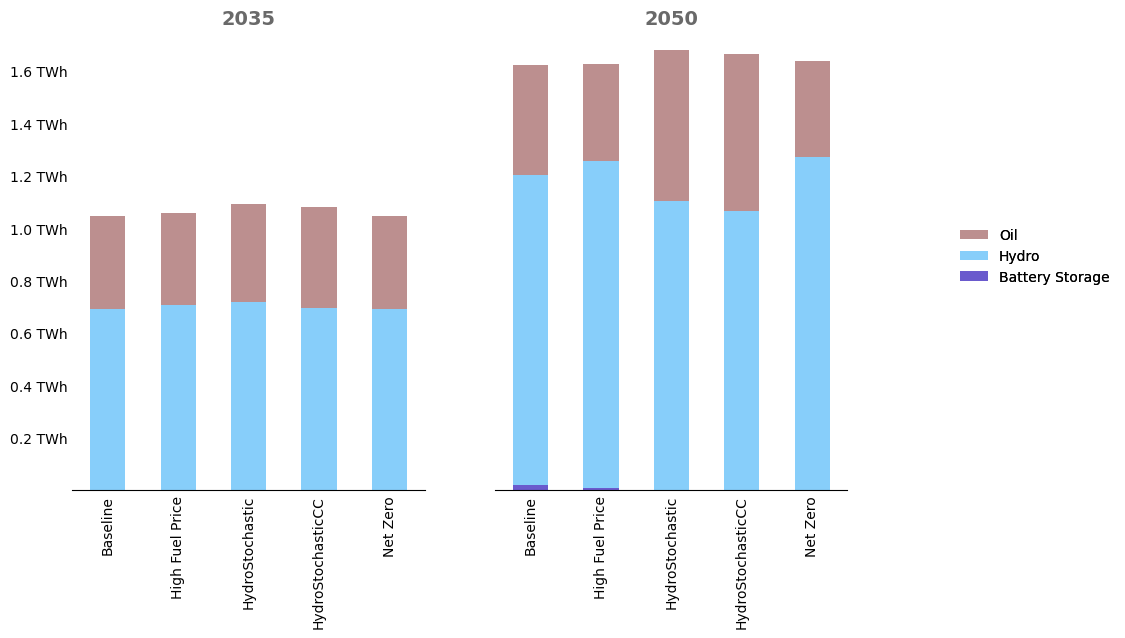

In [15]:
df = epm_results['pReserveByPlant'].copy()
df['value'] = df['value'] / 1e3
filename = f'{GRAPHS_RESULTS}/ReserveMixClusteredStackedAreaPlot.png'
filename = None # Only for display in the notebook

make_stacked_barplot(df, filename, dict_specs['colors'], column_stacked='fuel1', column_xaxis='year',
                          column_value='value', column_multiple_bars='scenario', select_xaxis=SELECT_XAXIS,
                          format_y=lambda y, _: '{:.1f} TWh'.format(y))

#### Cost Summary

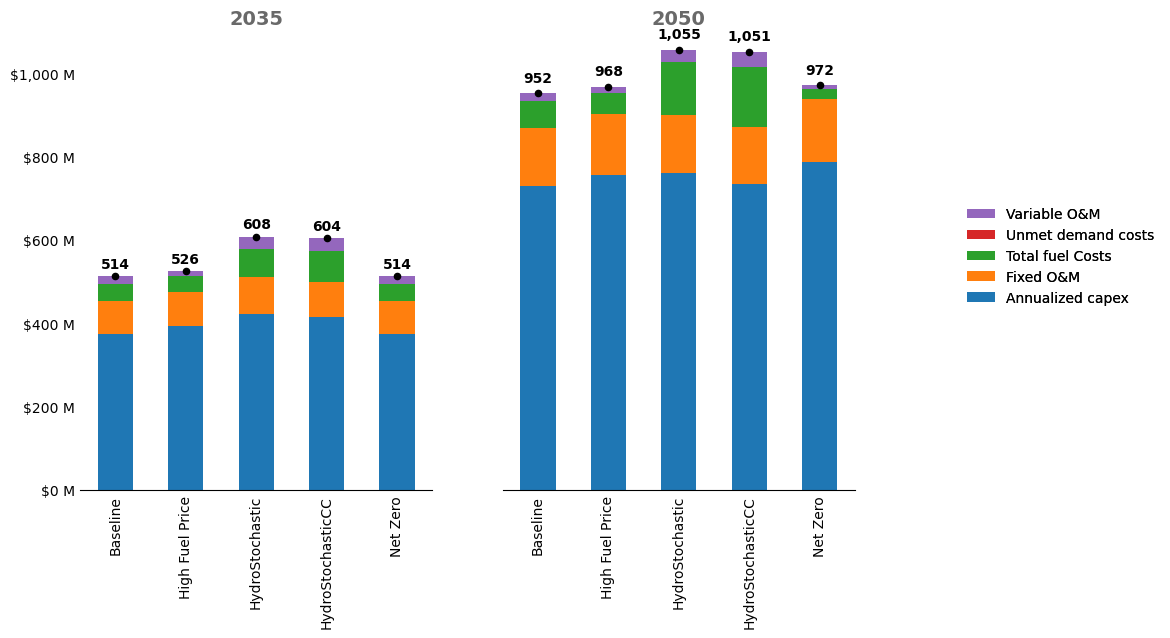

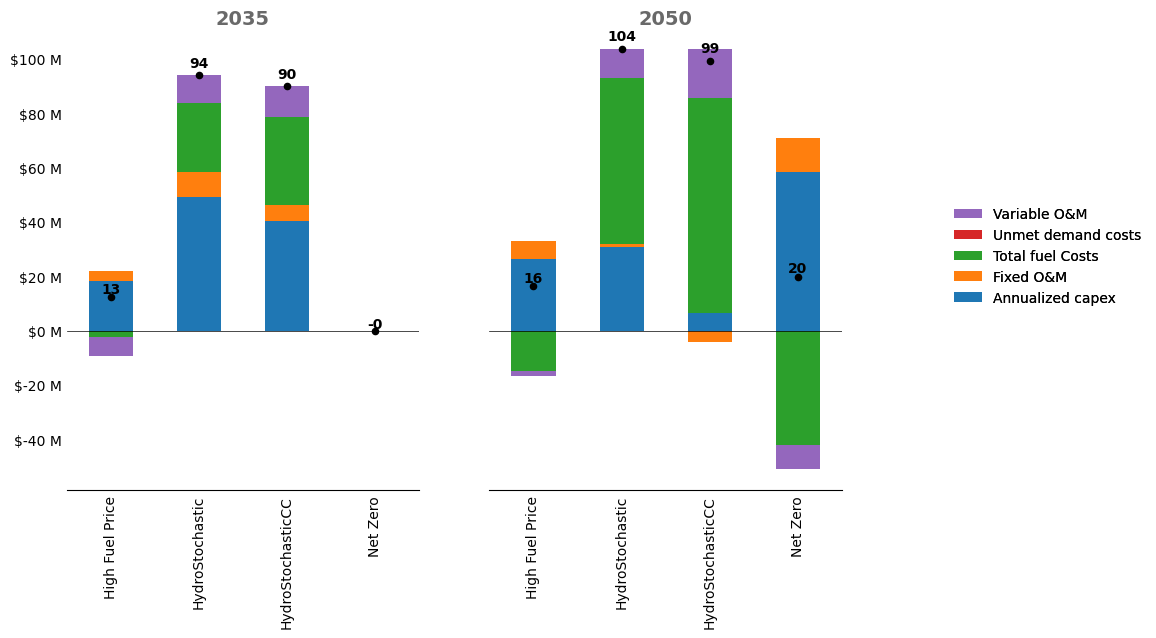

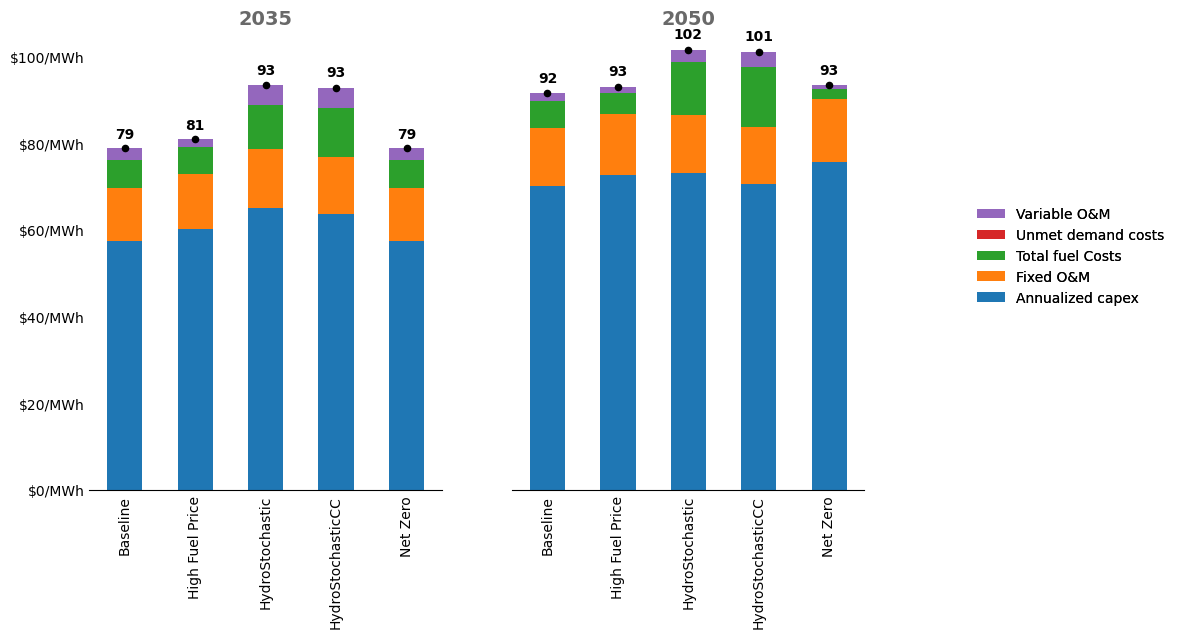

In [16]:
select_xaxis = SELECT_XAXIS
df = epm_results['pCostSummary'].copy()
df = df[~df['attribute'].isin(['Capex: $m', 'Total Annual Cost by Zone: $m'])]
df['attribute'] = df['attribute'].str.split(':').str[0]

filename = f'{GRAPHS_RESULTS}/CostClusteredStackedAreaPlot.png'
filename = None # Only for display in the notebook

make_stacked_barplot(df, filename, None, column_stacked='attribute', column_xaxis='year',
                          column_value='value', column_multiple_bars='scenario', select_xaxis=SELECT_XAXIS,
                          format_y=lambda y, _: '${:,.0f} M'.format(y), annotate=False, show_total=True)


# Make difference with baseline to highlight changes
if 'Baseline' in df['scenario'].unique() and len(df['scenario'].unique()) > 1:
    df_diff = df.pivot_table(index=['zone', 'year', 'attribute'], columns='scenario', values='value')
    df_diff = (df_diff.T - df_diff['Baseline']).T
    df_diff = df_diff.drop('Baseline', axis=1)
    df_diff = df_diff.stack().reset_index()
    df_diff.rename(columns={0: 'value'}, inplace=True)
    
    filename = f'{GRAPHS_RESULTS}/CostClusteredStackedAreaPlot_Diff.png'
    filename = None # Only for display in the notebook

    make_stacked_barplot(df_diff, filename, None, column_stacked='attribute', column_xaxis='year',
                              column_value='value', column_multiple_bars='scenario', select_xaxis=SELECT_XAXIS,
                              format_y=lambda y, _: '${:,.0f} M'.format(y), annotate=False, show_total=True)
    
# Figure in dollar per energy unit    
energy = epm_input['pDemandForecast'].copy()
energy = energy[energy['uni_1'] == 'Energy']
energy = energy.groupby(['scenario', 'zone', 'year'])['value'].sum().reset_index()
energy = energy.rename(columns={'value': 'energy'})
df = epm_results['pCostSummary'].copy()
df = df[~df['attribute'].isin(['Capex: $m', 'Total Annual Cost by Zone: $m'])]
df['attribute'] = df['attribute'].str.split(':').str[0]
#energy = energy[energy['year'].isin(df['year'].unique())]
df = pd.merge(df, energy, on=['scenario', 'zone', 'year'])
df['value'] = df['value']*1e6 / (df['energy']*1e3)
filename = f'{GRAPHS_RESULTS}/CostEnergyClusteredStackedAreaPlot.png'
filename = None # Only for display in the notebook

make_stacked_barplot(df, filename, None, column_stacked='attribute', column_xaxis='year',
                          column_value='value', column_multiple_bars='scenario', select_xaxis=SELECT_XAXIS,
                          format_y=lambda y, _: '${:.0f}/MWh'.format(y), annotate=False, show_total=True)


In [17]:
# Not yet implemented
if False:
    # Investment need by year (Capex cumulated)
    df = epm_results['pCostSummary'].copy()
    df = df[df['attribute'] == 'Capex: $m']
    df = df.sort_values(by=['scenario', 'zone', 'year'])
    df['value'] = df.groupby(['scenario', 'zone'])['value'].cumsum()
    
    df.plot(x='year', y='value')

#### LCOE function of Energy and Capacity

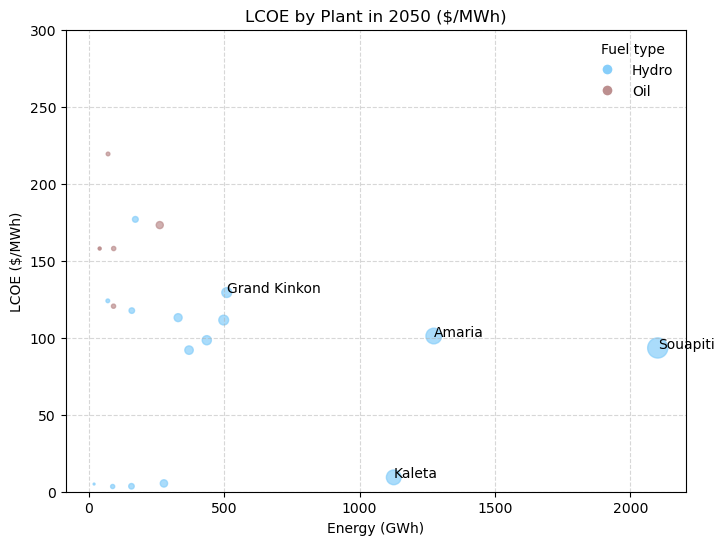

In [18]:
# To make the figures for all scenarios and all years
if False:
    for scenario in epm_results['pPlantAnnualLCOE']['scenario'].unique():
    
        column_xaxis = 'Energy (GWh)'
        column_value = 'LCOE ($/MWh)'
        
        df = epm_results['pPlantAnnualLCOE'].copy()
        df = df.rename(columns={'value': column_value})
        df1 = epm_results['pEnergyByPlant'].copy()
        df1 = df1.rename(columns={'value': column_xaxis})
        df = df.merge(df1, on=['scenario', 'zone', 'generator', 'year', 'fuel1'])
        
        color_col = 'fuel1'
        years = SELECT_XAXIS
        #df[column_value] /= 1e3
        
        for year in years:
            temp = df[df['year'] == year]
            temp = temp[temp['scenario'] == scenario]
            # only if energy is positive
            temp = temp[temp[column_xaxis] > 1]
            temp = temp[temp[color_col].isin(['Hydro', 'Oil', 'Oil diesel'])]
        
            filename = f'{GRAPHS_RESULTS}/LCOEvsEnergy_{year}_{scenario}.png'
            make_scatter_plot(temp, column_xaxis, column_value, color_col, dict_specs['colors'],
                                     ymax=300, title='LCOE by Plant in {} ($/MWh)'.format(year), legend='Fuel type',
                                     filename=filename, xmax=None, size_scale=0.1, annotate_thresh=500)
else:
    scenario, year = selected_scenario, 2050
    
    column_xaxis = 'Energy (GWh)'
    column_value = 'LCOE ($/MWh)'
    
    df = epm_results['pPlantAnnualLCOE'].copy()
    df = df.rename(columns={'value': column_value})
    df1 = epm_results['pEnergyByPlant'].copy()
    df1 = df1.rename(columns={'value': column_xaxis})
    df = df.merge(df1, on=['scenario', 'zone', 'generator', 'year', 'fuel1'])
    
    color_col = 'fuel1'
    years = SELECT_XAXIS
    
    temp = df[df['year'] == year]
    temp = temp[temp['scenario'] == scenario]
    # only if energy is positive
    temp = temp[temp[column_xaxis] > 1]
    temp = temp[temp[color_col].isin(['Hydro', 'Oil', 'Oil diesel'])]

    filename = f'{GRAPHS_RESULTS}/LCOEvsEnergy_{year}_{scenario}.png'
    filename = None # Only for display in the notebook
    make_scatter_plot(temp, column_xaxis, column_value, color_col, dict_specs['colors'],
                             ymax=300, title='LCOE by Plant in {} ($/MWh)'.format(year), legend='Fuel type',
                             filename=filename, xmax=None, size_scale=0.1, annotate_thresh=500)
    

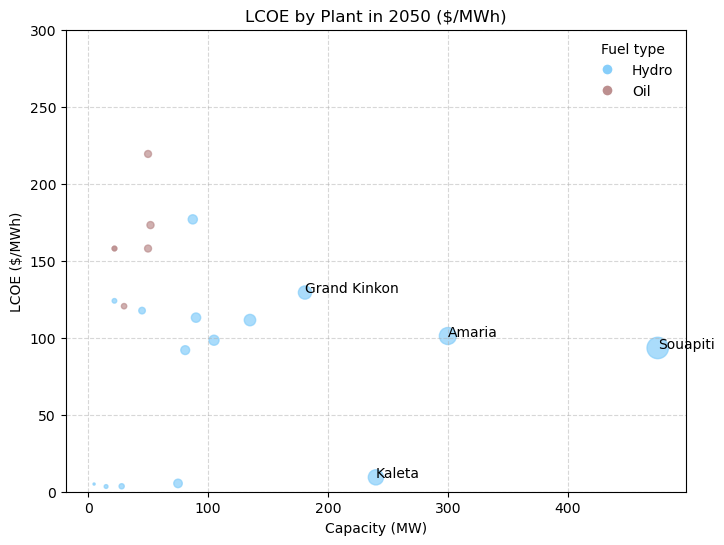

In [19]:
column_xaxis = 'Capacity (MW)'
column_value = 'LCOE ($/MWh)'

df = epm_results['pPlantAnnualLCOE'].copy()
df = df.rename(columns={'value': column_value})
df1 = epm_results['pCapacityPlan'].copy()
df1 = df1.rename(columns={'value': column_xaxis})
df = df.merge(df1, on=['scenario', 'zone', 'generator', 'year', 'fuel1'])

color_col = 'fuel1'
years = SELECT_XAXIS
#df[column_value] /= 1e3

years = [2050]
for year in years:
    temp = df[df['year'] == year]
    temp = temp[temp['scenario'] == selected_scenario]
    # only if energy is positive
    temp = temp[temp[column_xaxis] > 1]
    temp = temp[temp[color_col].isin(['Hydro', 'Oil', 'Oil diesel'])]

    filename = f'{GRAPHS_RESULTS}/LCOEvsCapacity_{year}.png'
    filename = None # Only for display in the notebook
    make_scatter_plot(temp, column_xaxis, column_value, color_col, dict_specs['colors'],
                             ymax=300, title='LCOE by Plant in {} ($/MWh)'.format(year), legend='Fuel type',
                             filename=filename, xmax=None, size_scale=0.5, annotate_thresh=150)

#### Emission

In [20]:
# Not yet implemented
if False:
    temp = epm_results['pEmissions'].copy()
    temp.drop('zone', axis=1, inplace=True)
    temp = temp.set_index(['scenario', 'year'])['value']
    temp = temp.unstack('scenario')
    temp.plot()